# File to analyze the well-mixed runs

In [2]:
# import of necessary files from other folders

import os
import sys
import ast

# libraries imports

import importlib
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import seaborn as sns
import pandas as pd
import pickle

from IPython.display import Image, display
from PIL import Image
from pathlib import Path
from scipy.integrate import solve_ivp
from matplotlib.colors import LinearSegmentedColormap,TwoSlopeNorm


# Set default figure and axes background color to white
plt.rcParams['figure.facecolor'] = 'white'  # Background for the entire figure
plt.rcParams['axes.facecolor'] = 'white' 

# Function to check if a string can be converted to a float or an integer
def is_number(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

## Import dataframes

In [8]:
networks_df = pd.read_pickle('/Users/federicasibilla/Downloads/Auxotrophs/generating_networks/generated_networks_df.pkl')
print(networks_df.head(1))
print(len(networks_df))

                   network_id  attempts  \
0  16_20_1_1_0.1_1.0_0.1_10_0         1   

                                          uptake_fac  \
0  [[1.1764052345967664, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                        uptake_oblig  \
0  [[1.1764052345967664, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                            spec_met  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...   

                                             met_fac  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                           met_oblig  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
660


In [21]:
# Assuming your DataFrame is named df
networks_df[['n_consumed', 'n_producers']] = networks_df['network_id'].str.split('_', expand=True).iloc[:, 2:4].astype(int)

In [7]:
# Path to the results directory
results_directory_path = Path('/Users/federicasibilla/Downloads/Auxotrophs/running_wm/run_results')

# List to accumulate the data
rows = []

# Get all folders and sort them alphabetically
folders = (results_directory_path.iterdir())

# Loop over all items in the sorted list of folders
for folder in folders:
    if folder.is_dir():

        parameters = folder.name
        
        # Check and convert only the parts that can be numbers (floats or integers)
        parameters_list = [float(value) if '.' in value else int(value) for value in parameters.split('_') if is_number(value)]
        
        # Construct the full path of the pickle file
        pickle_file_path = folder / 'all_data.pkl'
        
        if pickle_file_path.exists():
            # Load data from the pickle file
            with open(pickle_file_path, 'rb') as file:
                data = pickle.load(file)

            CR_R_F=data['CR_R_F']
            CR_R_O=data['CR_R_O']
            CR_N_F=data['CR_N_F']
            CR_N_O=data['CR_N_O']
        
            # Create a new row and add it to the rows list
            new_row = parameters_list +[CR_R_F]+[CR_R_O]+[CR_N_F]+[CR_N_O]
            rows.append(new_row)

# Create a new DataFrame with the accumulated rows
df_run = pd.DataFrame(rows, columns=['iloc_idx','leakage','CR_R_F','CR_R_O','CR_N_F','CR_N_O'])

print(df_run.head(1))
print(len(df_run))

   iloc_idx  leakage                                             CR_R_F  \
0         1      0.2  [[10000.0, 10000.0, 10000.0, 10000.0, 10000.0,...   

                                              CR_R_O  \
0  [[10000.0, 10000.0, 10000.0, 10000.0, 10000.0,...   

                                              CR_N_F  \
0  [[0.8232569704871391, 1.0168046510338506, 0.92...   

                                              CR_N_O  
0  [[0.8232569704871391, 1.0168046510338506, 0.92...  
2


## Merge the two dataframes

In [22]:
# Step 1: Add iloc index as a column in networks_df
networks_df = networks_df.copy()
networks_df['iloc_idx_1'] = networks_df.index

# Step 2: Ensure df_run['index'] is int for matching
df_run['iloc_idx'] = df_run['iloc_idx'].astype(int)

# Step 3: Merge the two DataFrames on the matching index values
merged_df = pd.merge(
    networks_df,
    df_run,
    left_on='iloc_idx_1',
    right_on='iloc_idx',
    how='inner'  # only keep rows present in both
)


# Check the result
print(len(merged_df))
merged_df.head()

2


,network_id,attempts,uptake_fac,uptake_oblig,spec_met,met_fac,met_oblig,iloc_idx_x,iloc_idx_1,n_consumed,n_producers,iloc_idx_y,leakage,CR_R_F,CR_R_O,CR_N_F,CR_N_O
0,16_20_1_1_0.1_1.0_0.1_10_0,1,"[[1.1764052345967664, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.1764052345967664, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0,1,1,0,0.2,"[[10000.0, 10000.0, 10000.0, 10000.0, 10000.0,...","[[10000.0, 10000.0, 10000.0, 10000.0, 10000.0,...","[[1.1405230523799093, 1.08229984924342, 0.7397...","[[1.1405230523799093, 1.08229984924342, 0.7397..."
1,16_20_1_1_0.1_1.0_0.1_10_1,1,"[[1.1624345363663242, 0.0, 0.0, 0.0, 0.0, 1.11...","[[1.1624345363663242, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,1,1,1,1,0.2,"[[10000.0, 10000.0, 10000.0, 10000.0, 10000.0,...","[[10000.0, 10000.0, 10000.0, 10000.0, 10000.0,...","[[0.8232569704871391, 1.0168046510338506, 0.92...","[[0.8232569704871391, 1.0168046510338506, 0.92..."


## Filter for collapse

Make df_survived where only the non collapsed ones are kept

In [23]:
merged_df['richness_F']=merged_df['CR_N_F'].apply(lambda x: np.sum(np.where(x[0][-1]>0.01,1,0)))
merged_df['richness_O']=merged_df['CR_N_O'].apply(lambda x: np.sum(np.where(x[0][-1]>0.01,1,0)))

In [24]:
merged_df['collapse_F']=np.where(merged_df['richness_F']<1,'yes','no')
merged_df['collapse_O']=np.where(merged_df['richness_O']<1,'yes','no')

In [25]:
df_survived=merged_df[(merged_df['collapse_F']=='no')&(merged_df['collapse_O']=='no')]

In [26]:
len(df_survived)

2

## Filter for steady state

make df_check where the non collapsed and steady state obnes only are kept

In [27]:
# Define a function to check for steady state for multiple series
def has_steady_state_multi(row, threshold=1e-2, window_size=10):
    """
    Check if both CR_N_O and CR_N_F have reached a steady state.

    Parameters:
    - row: pandas Series, containing the columns to check.
    - threshold: float, the maximum allowable change to consider steady.
    - window_size: int, the number of points to check for stability.

    Returns:
    - bool: True if both CR_N_O and CR_N_F are steady, False otherwise.
    """
    # Convert the columns to numpy arrays
    cr_n_o = np.array(row['CR_N_O'])[0]
    cr_n_f = np.array(row['CR_N_F'])[0]
    
    # Check if the time series are long enough
    if len(cr_n_o) < window_size or len(cr_n_f) < window_size:
        return False  # Not enough points to determine steady state
    
    # Compute the absolute differences over the last window_size points for each series
    diff_o = np.abs(cr_n_o[-10] - cr_n_o[-1])
    diff_f = np.abs(cr_n_f[-10] - cr_n_f[-1])
    
    # Check if both series are steady
    return np.all(diff_o < threshold) and np.all(diff_f < threshold)

# Apply the steady-state check to the DataFrame
df_survived['is_steady'] = df_survived.apply(has_steady_state_multi, axis=1)

# Filter rows where steady state is reached for both CR_N_O and CR_N_F
df_check = df_survived[df_survived['is_steady']].copy()

# Drop the helper column if not needed
df_check.drop(columns=['is_steady'], inplace=True)

# Output the filtered DataFrame
len(df_check)

0

## Visualize distribution of collapsed and non steady state data

/var/folders/cz/ql9y2c0d30jfv4_wzd2p0bpw0000gn/T/ipykernel_25236/4087195812.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2
(0.00)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  annotations_F.loc[row, col] = f'{count}\n({prob_F:.2f})' if not pd.isnull(count) else ''
/var/folders/cz/ql9y2c0d30jfv4_wzd2p0bpw0000gn/T/ipykernel_25236/4087195812.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2
(0.00)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  annotations_O.loc[row, col] = f'{count}\n({prob_O:.2f})' if not pd.isnull(count) else ''


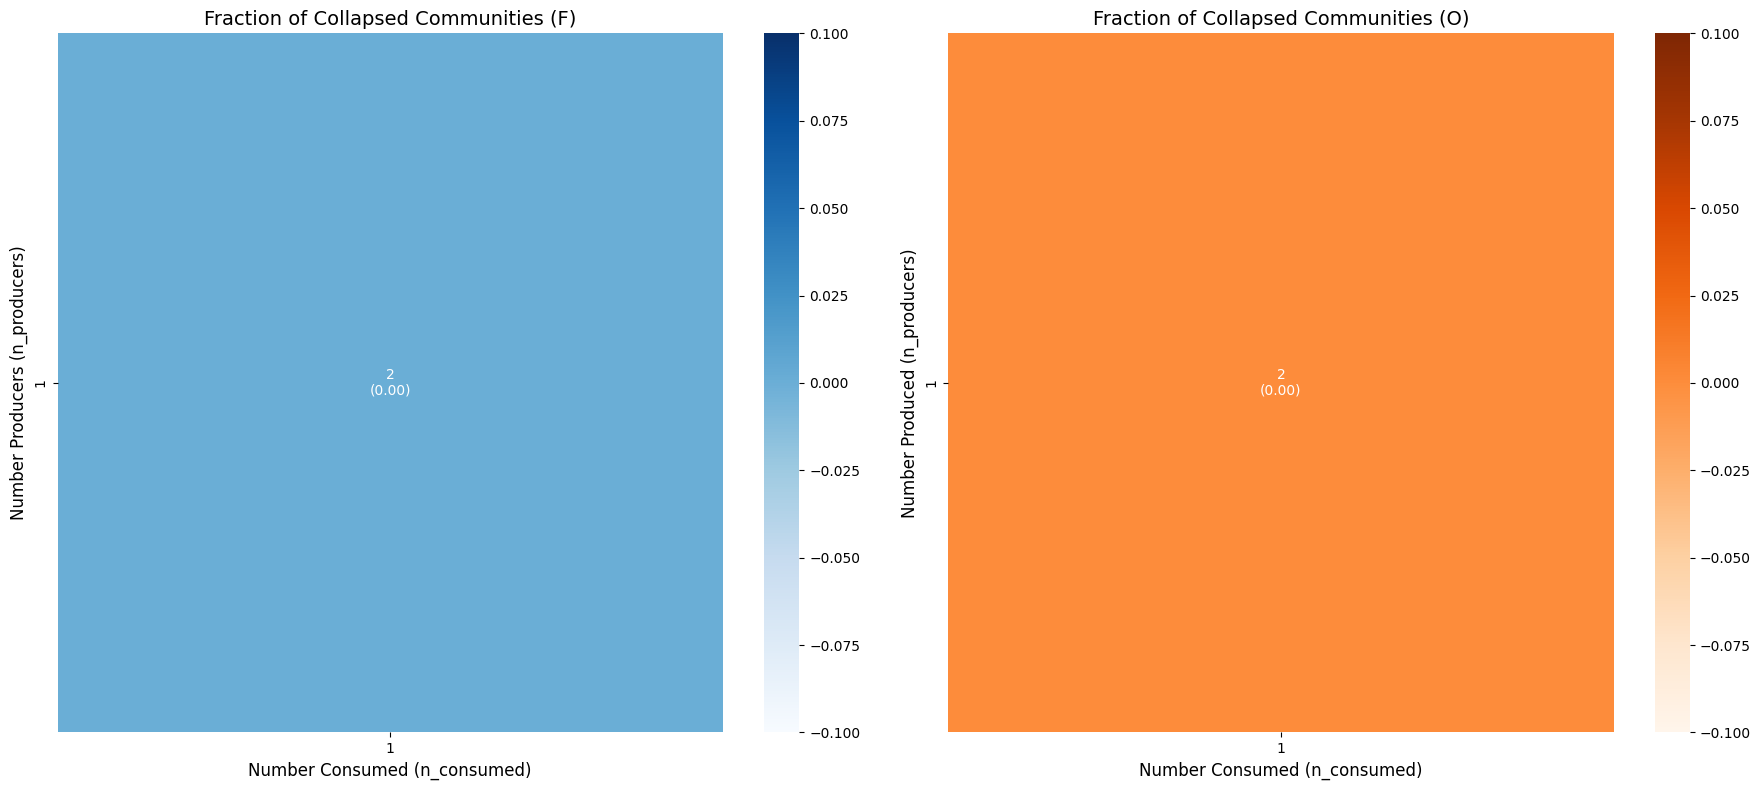

In [35]:
# check which ones have converged
# Group by `n_consumed` and `n_produced` to calculate collapse probabilities and counts
probabilities_with_counts = (
    merged_df.groupby(['n_consumed', 'n_producers'])
    .agg(
        prob_collapse_F=('collapse_F', lambda x: (x == 'yes').mean()),
        prob_collapse_O=('collapse_O', lambda x: (x == 'yes').mean()),
        count=('collapse_F', 'count')  # Add a count of points in each square
    )
    .reset_index()
)

# Pivot data for heatmaps
heatmap_data_F = probabilities_with_counts.pivot(index='n_producers', columns='n_consumed', values='prob_collapse_F')
heatmap_data_O = probabilities_with_counts.pivot(index='n_producers', columns='n_consumed', values='prob_collapse_O')
heatmap_counts = probabilities_with_counts.pivot(index='n_producers', columns='n_consumed', values='count')

# Create annotations combining counts and probabilities for F
annotations_F = heatmap_counts.copy()
for row in annotations_F.index:
    for col in annotations_F.columns:
        count = heatmap_counts.loc[row, col]
        prob_F = heatmap_data_F.loc[row, col] if pd.notnull(heatmap_data_F.loc[row, col]) else np.nan
        annotations_F.loc[row, col] = f'{count}\n({prob_F:.2f})' if not pd.isnull(count) else ''

# Create annotations combining counts and probabilities for O
annotations_O = heatmap_counts.copy()
for row in annotations_O.index:
    for col in annotations_O.columns:
        count = heatmap_counts.loc[row, col]
        prob_O = heatmap_data_O.loc[row, col] if pd.notnull(heatmap_data_O.loc[row, col]) else np.nan
        annotations_O.loc[row, col] = f'{count}\n({prob_O:.2f})' if not pd.isnull(count) else ''

# Set up the figure for two heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Heatmap for Collapse F with annotations
sns.heatmap(
    heatmap_data_F, 
    ax=axes[0], 
    cmap='Blues', 
    annot=annotations_F,  # Overlay count and O probability annotations
    fmt='',  # Use raw string annotations
    cbar=True
)
axes[0].set_title('Fraction of Collapsed Communities (F)', fontsize=14)
axes[0].set_xlabel('Number Consumed (n_consumed)', fontsize=12)
axes[0].set_ylabel('Number Producers (n_producers)', fontsize=12)

# Heatmap for Collapse O with annotations
sns.heatmap(
    heatmap_data_O, 
    ax=axes[1], 
    cmap='Oranges', 
    annot=annotations_O,  # Overlay count and F probability annotations
    fmt='',  # Use raw string annotations
    cbar=True
)
axes[1].set_title('Fraction of Collapsed Communities (O)', fontsize=14)
axes[1].set_xlabel('Number Consumed (n_consumed)', fontsize=12)
axes[1].set_ylabel('Number Produced (n_producers)', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

/var/folders/cz/ql9y2c0d30jfv4_wzd2p0bpw0000gn/T/ipykernel_25236/3950263112.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2
(0.00)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  annotations_F.loc[row, col] = f'{count}\n({prob_F:.2f})' if not pd.isnull(count) else ''


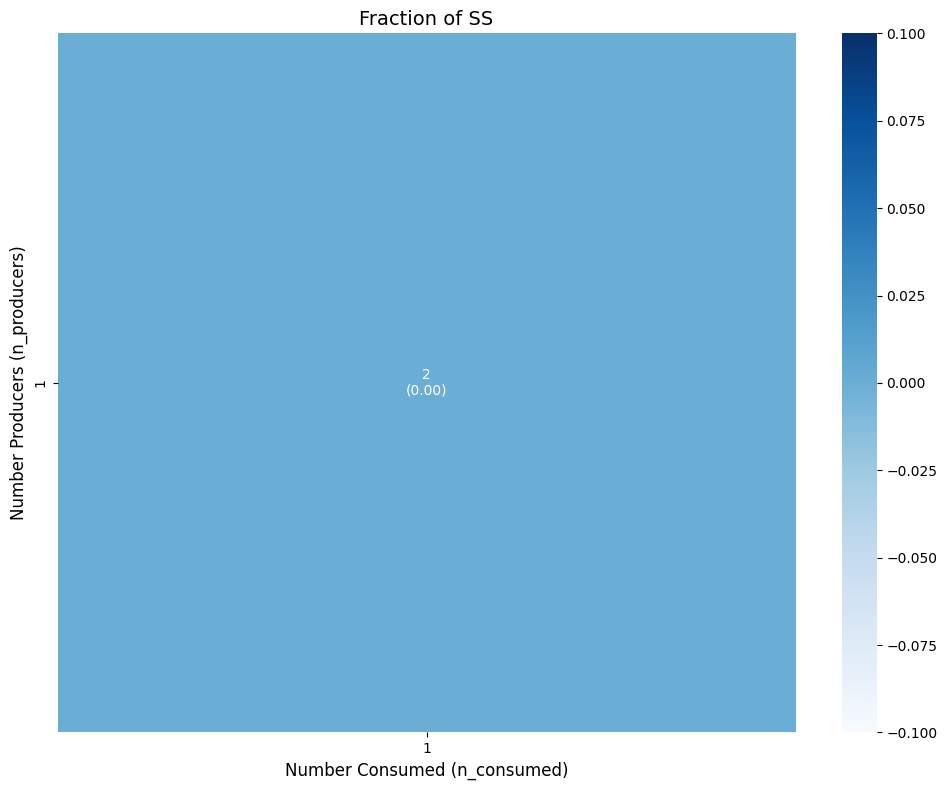

In [36]:
# check which ones have converged
# Group by `n_consumed` and `n_produced` to calculate collapse probabilities and counts
probabilities_with_counts = (
    df_survived.groupby(['n_consumed', 'n_producers'])
    .agg(
        prob_steady=('is_steady', lambda x: (x == 1).mean()),
        count=('is_steady', 'count')  # Add a count of points in each square
    )
    .reset_index()
)

# Pivot data for heatmaps
heatmap_data = probabilities_with_counts.pivot(index='n_producers', columns='n_consumed', values='prob_steady')
heatmap_counts = probabilities_with_counts.pivot(index='n_producers', columns='n_consumed', values='count')

# Create annotations combining counts and probabilities for F
annotations_F = heatmap_counts.copy()
for row in annotations_F.index:
    for col in annotations_F.columns:
        count = heatmap_counts.loc[row, col]
        prob_F = heatmap_data.loc[row, col] if pd.notnull(heatmap_data.loc[row, col]) else np.nan
        annotations_F.loc[row, col] = f'{count}\n({prob_F:.2f})' if not pd.isnull(count) else ''


# Set up the figure
plt.figure(figsize=(10, 8))

# Heatmap for Collapse F with annotations
sns.heatmap(
    heatmap_data, 
    cmap='Blues', 
    annot=annotations_F,   # Overlay count and probability annotations
    fmt='',                 # Use raw string annotations
    cbar=True
)

plt.title('Fraction of SS', fontsize=14)
plt.xlabel('Number Consumed (n_consumed)', fontsize=12)
plt.ylabel('Number Producers (n_producers)', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

## Diversity for the ss non collapsed

/Users/federicasibilla/Downloads/Auxotrophs/aux_env/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/Users/federicasibilla/Downloads/Auxotrophs/aux_env/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/Users/federicasibilla/Downloads/Auxotrophs/aux_env/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/Users/federicasibilla/Downloads/Auxotrophs/aux_env/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to se

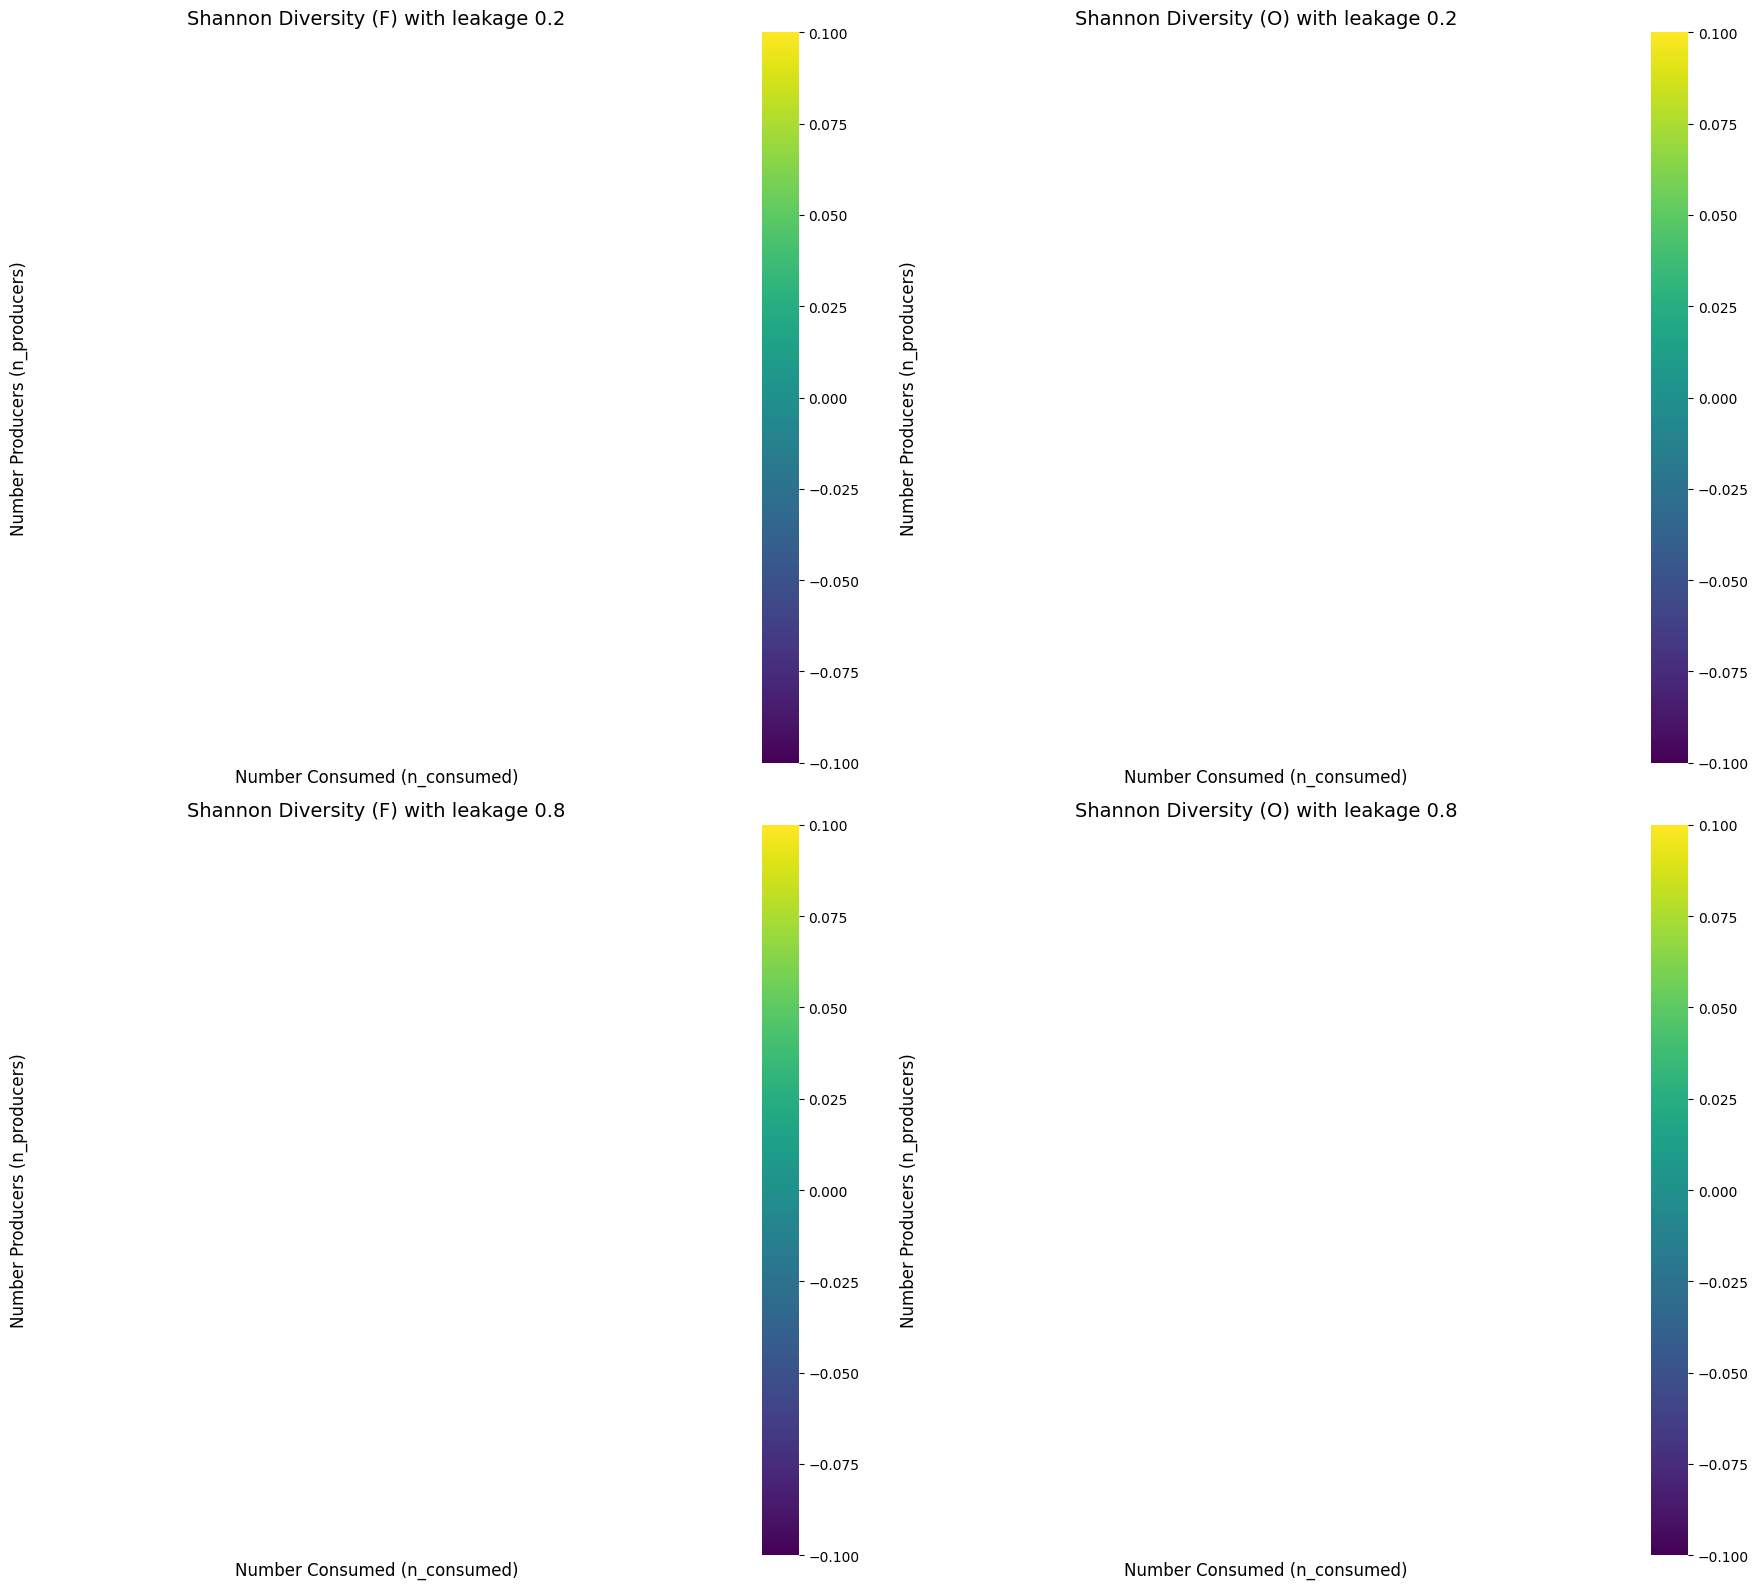

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Filter data based on leakage values
df_leakage_02 = df_check[df_check['leakage'] == 0.2]
df_leakage_08 = df_check[df_check['leakage'] == 0.8]

# Compute Shannon diversity and add it as a new column
df_leakage_02['shannon_F'] = df_leakage_02['CR_N_F'].apply(lambda x: entropy(x[0][-1], base=np.e))
df_leakage_02['shannon_O'] = df_leakage_02['CR_N_O'].apply(lambda x: entropy(x[0][-1], base=np.e))
df_leakage_08['shannon_F'] = df_leakage_08['CR_N_F'].apply(lambda x: entropy(x[0][-1], base=np.e))
df_leakage_08['shannon_O'] = df_leakage_08['CR_N_O'].apply(lambda x: entropy(x[0][-1], base=np.e))

# Group by `n_consumed` and `n_produced` to calculate probabilities, counts, and average Shannon diversity
def compute_probabilities_and_diversity(df):
    probabilities_with_counts = (
        df.groupby(['n_consumed', 'n_producers'])
        .agg(
            prob_collapse_F=('collapse_F', lambda x: (x == 'yes').mean()),
            prob_collapse_O=('collapse_O', lambda x: (x == 'yes').mean()),
            count=('collapse_F', 'count'),
            avg_shannon_F=('shannon_F', 'mean'),
            avg_shannon_O=('shannon_O', 'mean')
        )
        .reset_index()
    )
    return probabilities_with_counts

probabilities_with_counts_02 = compute_probabilities_and_diversity(df_leakage_02)
probabilities_with_counts_08 = compute_probabilities_and_diversity(df_leakage_08)

# Pivot data for heatmaps
def pivot_heatmap_data(probabilities_with_counts):
    heatmap_data_F = probabilities_with_counts.pivot(index='n_producers', columns='n_consumed', values='avg_shannon_F')
    heatmap_data_O = probabilities_with_counts.pivot(index='n_producers', columns='n_consumed', values='avg_shannon_O')
    heatmap_counts = probabilities_with_counts.pivot(index='n_producers', columns='n_consumed', values='count')
    return heatmap_data_F, heatmap_data_O, heatmap_counts

heatmap_data_F_02, heatmap_data_O_02, heatmap_counts_02 = pivot_heatmap_data(probabilities_with_counts_02)
heatmap_data_F_08, heatmap_data_O_08, heatmap_counts_08 = pivot_heatmap_data(probabilities_with_counts_08)

# Set up the figure for four heatmaps with a common colorbar
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Determine the common color scale limits
vmin = min(heatmap_data_F_02.min().min(), heatmap_data_O_02.min().min(), heatmap_data_F_08.min().min(), heatmap_data_O_08.min().min())
vmax = max(heatmap_data_F_02.max().max(), heatmap_data_O_02.max().max(), heatmap_data_F_08.max().max(), heatmap_data_O_08.max().max())

# Heatmap for Shannon F with leakage 0.2
sns.heatmap(
    heatmap_data_F_02, 
    ax=axes[0, 0], 
    cmap='viridis', 
    annot=True,  
    fmt='.3f',  # Format to show 3 digits after the comma
    cbar=True,
    vmin=vmin, vmax=vmax
)
axes[0, 0].set_title('Shannon Diversity (F) with leakage 0.2', fontsize=14)
axes[0, 0].set_xlabel('Number Consumed (n_consumed)', fontsize=12)
axes[0, 0].set_ylabel('Number Producers (n_producers)', fontsize=12)

# Heatmap for Shannon O with leakage 0.2
sns.heatmap(
    heatmap_data_O_02, 
    ax=axes[0, 1], 
    cmap='viridis', 
    annot=True,  
    fmt='.3f',  # Format to show 3 digits after the comma
    cbar=True,
    vmin=vmin, vmax=vmax
)
axes[0, 1].set_title('Shannon Diversity (O) with leakage 0.2', fontsize=14)
axes[0, 1].set_xlabel('Number Consumed (n_consumed)', fontsize=12)
axes[0, 1].set_ylabel('Number Producers (n_producers)', fontsize=12)

# Heatmap for Shannon F with leakage 0.8
sns.heatmap(
    heatmap_data_F_08, 
    ax=axes[1, 0], 
    cmap='viridis', 
    annot=True,  
    fmt='.3f',  # Format to show 3 digits after the comma
    cbar=True,
    vmin=vmin, vmax=vmax
)
axes[1, 0].set_title('Shannon Diversity (F) with leakage 0.8', fontsize=14)
axes[1, 0].set_xlabel('Number Consumed (n_consumed)', fontsize=12)
axes[1, 0].set_ylabel('Number Producers (n_producers)', fontsize=12)

# Heatmap for Shannon O with leakage 0.8
sns.heatmap(
    heatmap_data_O_08, 
    ax=axes[1, 1], 
    cmap='viridis', 
    annot=True,  
    fmt='.3f',  # Format to show 3 digits after the comma
    cbar=True,
    vmin=vmin, vmax=vmax
)
axes[1, 1].set_title('Shannon Diversity (O) with leakage 0.8', fontsize=14)
axes[1, 1].set_xlabel('Number Consumed (n_consumed)', fontsize=12)
axes[1, 1].set_ylabel('Number Producers (n_producers)', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()